## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [23]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

%config InlineBackend.figure_format='retina'

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [7]:
len(fmnist_dataset_test)

10000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [9]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
    

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.07
----------------------------------------------------------------


Your experiments come here:

In [14]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
num_epochs = 100

for epoch in range(num_epochs):
    model.train()

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        opt.zero_grad()
        output = model(x_batch)
        loss = loss_func(output, y_batch)
        loss.backward()
        opt.step()

    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch}, Accuracy: {accuracy}')

    if accuracy >= 0.885:
        print("Desired accuracy achieved.")
        break

Epoch 0, Accuracy: 0.8403
Epoch 1, Accuracy: 0.8523
Epoch 2, Accuracy: 0.8601
Epoch 3, Accuracy: 0.8591
Epoch 4, Accuracy: 0.8677
Epoch 5, Accuracy: 0.8665
Epoch 6, Accuracy: 0.8702
Epoch 7, Accuracy: 0.8742
Epoch 8, Accuracy: 0.872
Epoch 9, Accuracy: 0.8746
Epoch 10, Accuracy: 0.8831
Epoch 11, Accuracy: 0.8791
Epoch 12, Accuracy: 0.8766
Epoch 13, Accuracy: 0.8845
Epoch 14, Accuracy: 0.8834
Epoch 15, Accuracy: 0.8793
Epoch 16, Accuracy: 0.8808
Epoch 17, Accuracy: 0.8856
Desired accuracy achieved.


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [74]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [75]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                 [-1, 1024]         263,168
              ReLU-5                 [-1, 1024]               0
            Linear-6                  [-1, 256]         262,400
              ReLU-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
Total params: 729,098
Trainable params: 729,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.78
Estimated Total Size (MB): 2.81
----------------------------------------------------------------


In [146]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

# small_train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(fmnist_dataset_train, range(1000)), 
#                                                  batch_size=128, shuffle=True)


train_over_losses = []
test_over_losses = []
train_over_accuracies = []
test_over_accuracies = []
num_epochs = 50 

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        opt.zero_grad()
        output = model(x_batch)
        loss = loss_func(output, y_batch)
        train_loss += loss.item()
        loss.backward()
        opt.step()
        _, predicted = torch.max(output.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_over_losses.append(train_loss / len(train_loader))
    train_over_accuracies.append(correct / total)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            outputs = model(x_batch)
            loss = loss_func(outputs, y_batch)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    
    test_over_losses.append(test_loss / len(test_loader))
    test_over_accuracies.append(accuracy)

    
    print(f'Epoch {epoch}, Test Accuracy: {accuracy}, Train Loss: {train_loss / len(train_loader)}, Test Loss: {test_loss / len(test_loader)}')

Epoch 0, Accuracy: 0.8298, Train Loss: 0.5303522431329369, Test Loss: 0.458658916503191
Epoch 1, Accuracy: 0.8606, Train Loss: 0.3657510426443523, Test Loss: 0.3776528384536505
Epoch 2, Accuracy: 0.862, Train Loss: 0.33063429457419463, Test Loss: 0.37103869915008547
Epoch 3, Accuracy: 0.8687, Train Loss: 0.30110032154298794, Test Loss: 0.3567078746855259
Epoch 4, Accuracy: 0.8768, Train Loss: 0.2875377124052312, Test Loss: 0.33532229717820883
Epoch 5, Accuracy: 0.8672, Train Loss: 0.27150763596680116, Test Loss: 0.3501232985407114
Epoch 6, Accuracy: 0.8811, Train Loss: 0.2545990214895592, Test Loss: 0.32310578003525736
Epoch 7, Accuracy: 0.8819, Train Loss: 0.2433614799621771, Test Loss: 0.3278191078454256
Epoch 8, Accuracy: 0.8835, Train Loss: 0.23728266258293124, Test Loss: 0.3264526041224599
Epoch 9, Accuracy: 0.8823, Train Loss: 0.22255169875077854, Test Loss: 0.32695673778653145
Epoch 10, Accuracy: 0.8821, Train Loss: 0.21599109481964537, Test Loss: 0.34560176469385623
Epoch 11, A

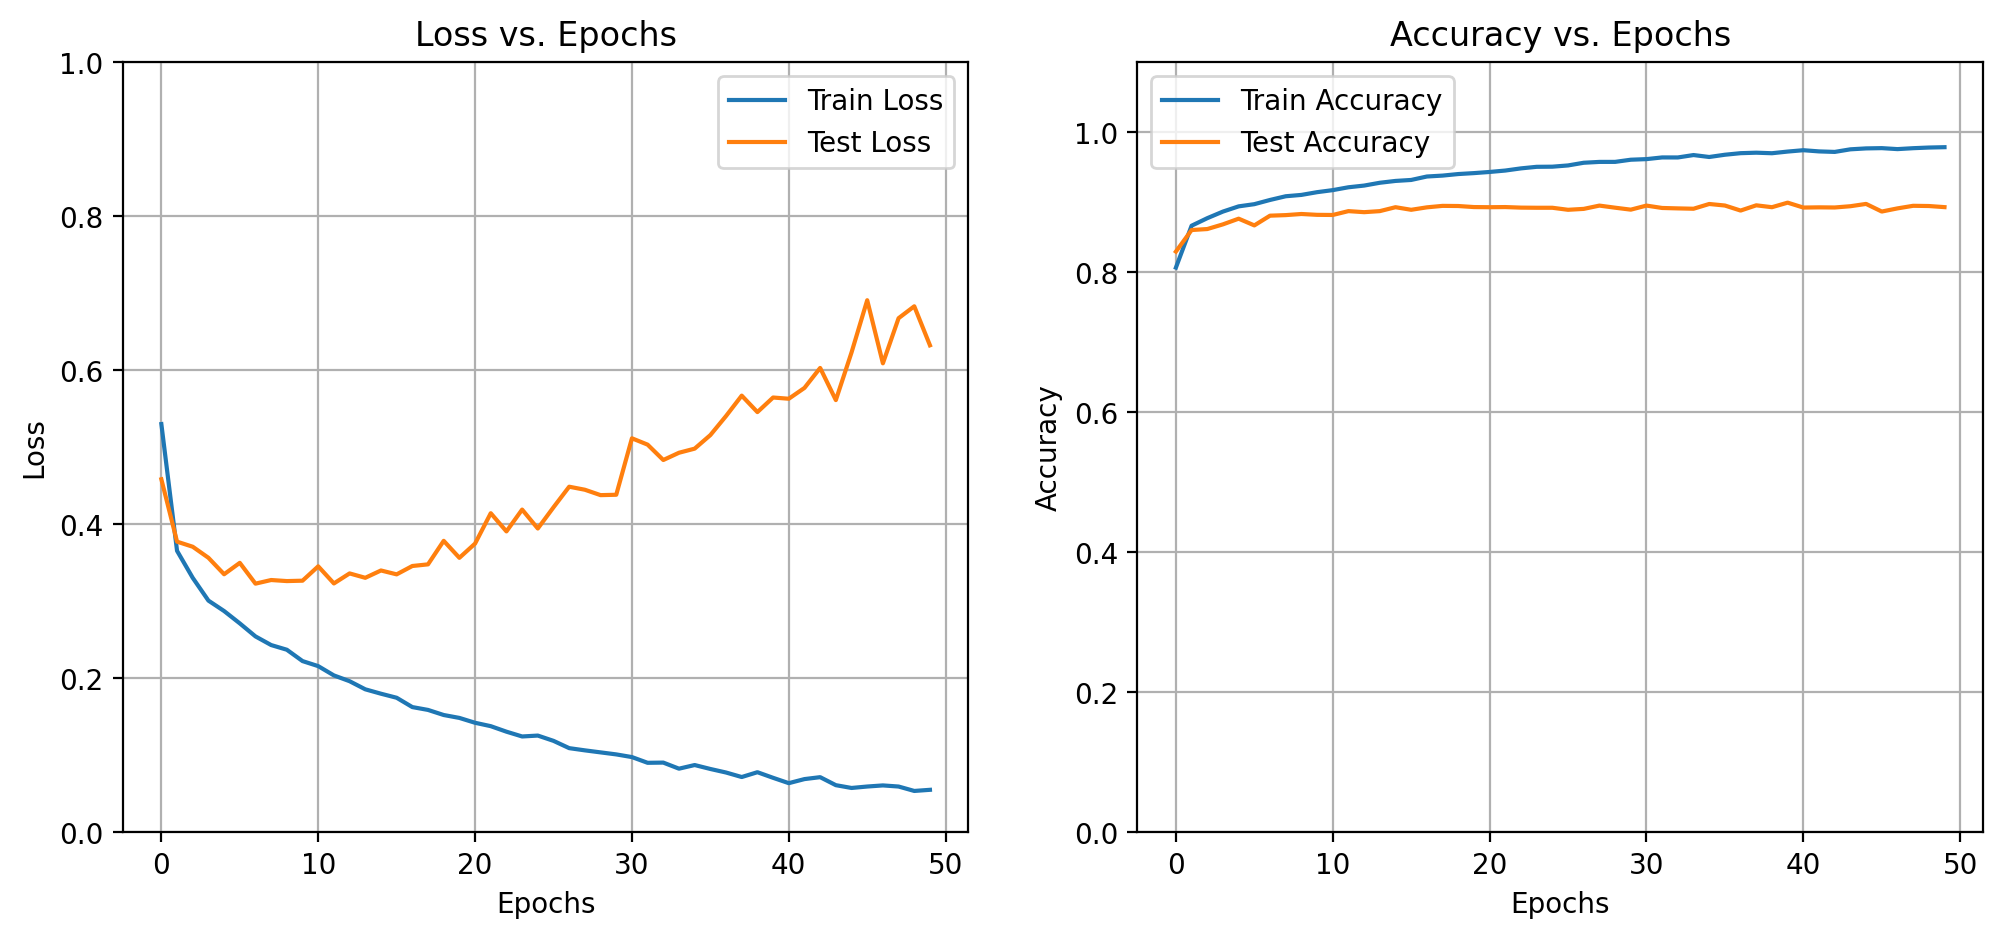

In [149]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_over_losses, label='Train Loss')
plt.plot(test_over_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.grid()
plt.ylim((0,1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_over_accuracies, label='Train Accuracy')
plt.plot(test_over_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.grid()
plt.ylim((0,1.1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [161]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [162]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                 [-1, 1024]         263,168
       BatchNorm1d-7                 [-1, 1024]           2,048
              ReLU-8                 [-1, 1024]               0
           Dropout-9                 [-1, 1024]               0
           Linear-10                  [-1, 256]         262,400
      BatchNorm1d-11                  [-1, 256]             512
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                   

In [159]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
num_epochs = 50 

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        opt.zero_grad()
        output = model(x_batch)
        loss = loss_func(output, y_batch)
        train_loss += loss.item()
        loss.backward()
        opt.step()
        _, predicted = torch.max(output.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = loss_func(outputs, y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(accuracy)

    
    print(f'Epoch {epoch}, Test Accuracy: {accuracy}, Train Loss: {train_loss / len(train_loader)}, Test Loss: {test_loss / len(test_loader)}')

Epoch 0, Test Accuracy: 0.8478, Train Loss: 0.5931613186656285, Test Loss: 0.40590424127876756
Epoch 1, Test Accuracy: 0.8495, Train Loss: 0.4466570409249141, Test Loss: 0.406938674300909
Epoch 2, Test Accuracy: 0.8629, Train Loss: 0.4121908370429265, Test Loss: 0.3657454621046782
Epoch 3, Test Accuracy: 0.8686, Train Loss: 0.3922157119522725, Test Loss: 0.35802263021469116
Epoch 4, Test Accuracy: 0.8714, Train Loss: 0.37695565571917145, Test Loss: 0.3482760604470968
Epoch 5, Test Accuracy: 0.8698, Train Loss: 0.36151842706239046, Test Loss: 0.3523204021155834
Epoch 6, Test Accuracy: 0.8735, Train Loss: 0.35106770208141186, Test Loss: 0.3425170794129372
Epoch 7, Test Accuracy: 0.8764, Train Loss: 0.3426250092256298, Test Loss: 0.33584118597209456
Epoch 8, Test Accuracy: 0.8779, Train Loss: 0.3355260559045938, Test Loss: 0.327049507945776
Epoch 9, Test Accuracy: 0.8814, Train Loss: 0.3262156346904189, Test Loss: 0.3201603889465332
Epoch 10, Test Accuracy: 0.8755, Train Loss: 0.319551968

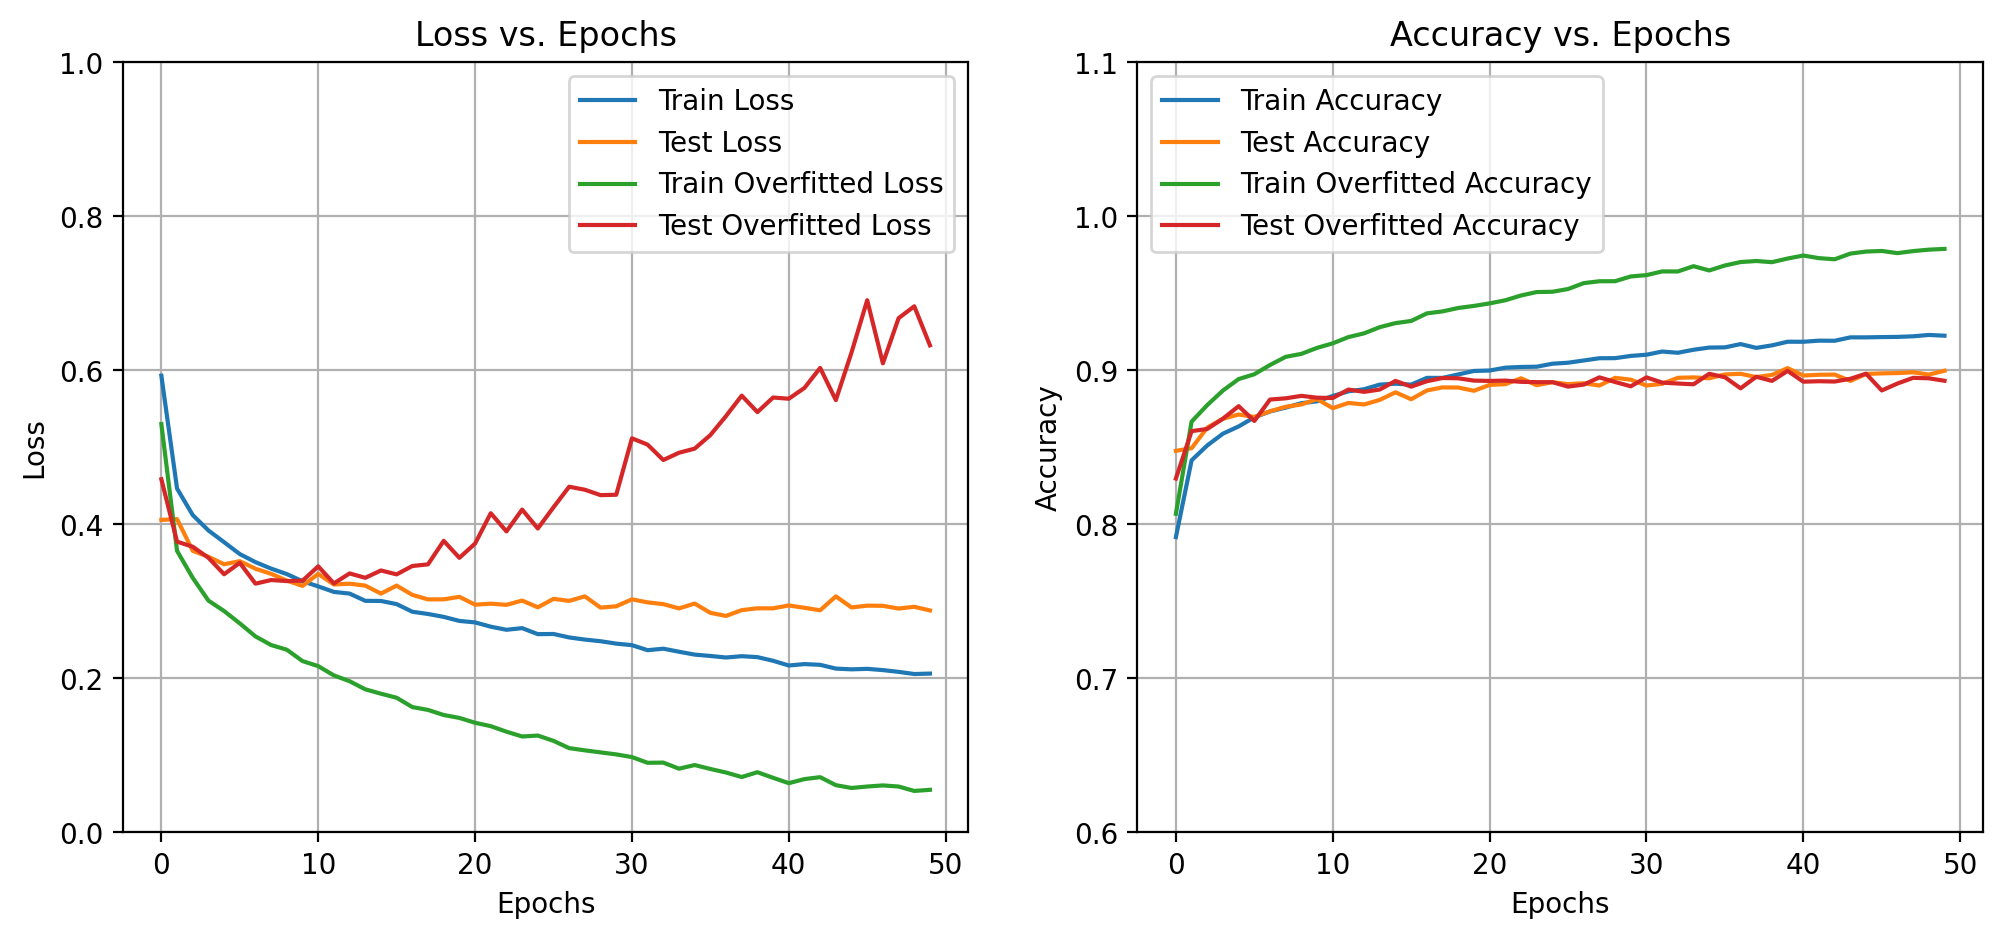

In [160]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(train_over_losses, label='Train Overfitted Loss')
plt.plot(test_over_losses, label='Test Overfitted Loss')
plt.title('Loss vs. Epochs')
plt.grid()
plt.ylim((0,1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(train_over_accuracies, label='Train Overfitted Accuracy')
plt.plot(test_over_accuracies, label='Test Overfitted Accuracy')
plt.title('Accuracy vs. Epochs')
plt.grid()
plt.ylim((0.6,1.1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Conclusions:

В первом задании запланированное значение accuracy $\ge 0.885$ достигается при помощи линейных слоев, ReLU и Dropout за 17 эпох.

Во втором задании сеть легко переобучается при отсутствии регуляризации: test loss уходит выше 0.6, а train loss на 50-й эпохе достигает значения 0.056. Train accuracy стремится к единице. Test accuracy выходит на плато в районе 10 эпох.

В третьем задании добавление Dropout и Batch Norm помогает частично устранить переобучение. На графике видно, что test loss теперь не уходит резко вверх при большом количестве эпох, а постепенно уменьшается, train loss принимает значения выше, чем у переобученной сети. Train accuracy идет вверх к единице, но не так резко, как это происходит у переобученной сети. Однако, если внимательно поглядеть на тренд графика, то видно, что при продолжении обучения сеть, вероятнее всего, переобучится.